Epoch 0: 9101 / 10000
Epoch 1: 9261 / 10000
Epoch 2: 9300 / 10000
Epoch 3: 9318 / 10000
Epoch 4: 9341 / 10000
Epoch 5: 9415 / 10000
Epoch 6: 9437 / 10000
Epoch 7: 9440 / 10000
Epoch 8: 9439 / 10000
Epoch 9: 9443 / 10000


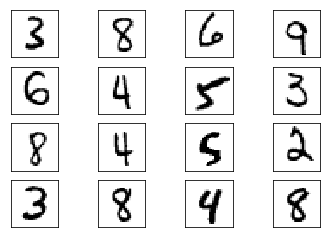

In [2]:
## import cPickle
import pickle
import gzip
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random


def load_data():
    # 读取压缩文件,　返回一个描述符
    f = gzip.open('mnist.pkl.gz', 'rb')
    ## training_data, validation_data, test_data = cPickle.load(f,encoding='bytes')
    # 从文件中读取数据
    training_data, validation_data, test_data = pickle.load(f,encoding='bytes')
    f.close()
    return (training_data, validation_data, test_data)

def showimage():
    # 加载数据
    training_set, validation_set, test_set = load_data()
    # 获取validation_set中的data数据(validation_set中存放两个array,第0个为图像数据,第1个为labels)
    # 此时flattened_images大小为(10000*784)
    flattened_images = validation_set[0]
    # 将validation_set中每行数据(即每个图像数据)转换为(28*28)的二维NumPy数组
    images = [np.reshape(f, (-1, 28)) for f in flattened_images]
    # 显示数字图像
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        ax.matshow(images[i], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

#　定义神经网络结构
class Network(object):
    def __init__(self, sizes):
        # 获取神经网络的层数
        self.num_layers = len(sizes)
        # sizes即每层神经元的个数
        self.sizes = sizes
        # 赋随机值（服从高斯分布）,对权重和偏向进行初始化
        # 　bais从第2行开始
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        # 　zip从传入的可循环的两组量中取出对应数据组成一个tuple
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    # 根据当前输入利用sigmoid函数来计算输出
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    # epochs训练多少轮, mini_batch_size抽取多少实例,eta学习率
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        # 测试集的大小
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        # j代表第几轮
        for j in range(epochs):
            # 将training_data中的数据随机打乱
            random.shuffle(training_data)
            # 将training_data中的数据随机打乱
            mini_batches = [training_data[k:k + mini_batch_size]
                # 从0到n每次间隔mini_batch_size张图片
                for k in range(0, n, mini_batch_size)]
            # 对取出来的mini_batchs逐个进行更新，更新weights和biases
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            # 每一轮训练后进行评估
            if test_data:
                print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

# eta:学习率  传入单个的mini_batch,根据其x.y值，对整个神经网络的wights和biases进行更新
    def update_mini_batch(self, mini_batch, eta):
        # 初始化
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # 计算对应的偏导数
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        # 权重weights更新　W'k=Wk-(eta/m)&C/&Wk
        self.weights = [w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nabla_w)]
        # 偏向biases更新  b'k=bk-(ets/m)&C/&bk
        self.biases = [b - (eta / len(mini_batch)) * nb
                       for b, nb in zip(self.biases, nabla_b)]

    # 计算对应的偏导数
    def backprop(self, x, y):
        # 返回一个元组（nabla_b，nabla_w）代表成本函数C_x的渐变。
        # nabla_b和nabla_w是numpy数组np.array的逐层列表,类似于self.biases和self.weights.
        # 分别生成与biases　weights等大小的0矩阵
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # 激活项
        activation = x
        # 列表存储所有的激活,逐层
        activations = [x]
        # 列表存储所有的激活,逐层
        zs = []
        for b, w in zip(self.biases, self.weights):
            # 计算中间变量  Z=W*X+b
            z = np.dot(w, activation) + b
            # 列表存储所有中间向量z
            zs.append(z)
            # 激活activation=sigmoid(W*X+b)
            activation = sigmoid(z)
            # 激活activation=sigmoid(W*X+b)
            activations.append(activation)
        # 反向更新
        # ### 输出层
        # 计算输出层error=Oj(1-Oj)(Tj-Oj);
        # cost_derivative(activations[-1], y)即Ｃ对a的梯度:(Tj-Oj)
        # sigmoid_prime(zs[-1])即:Oj(1-Oj)
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        # 更新输出层的nabla_b,nabla_w
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # ### 隐藏层
        # l = 1表示神经元的最后一层,l = 2是第二层,依此类推.反向更新直到初始层
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            # weights[-l + 1]即下一层的权重,
            delta = np.dot(self.weights[-l + 1].transpose(), delta) * sp
            nabla_b[-l] = delta
            # 输出C对w,b的偏导
            nabla_w[-l] = np.dot(delta, activations[-l - 1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        # 返回神经网络输出正确结果的测试输入的数量。 注意，神经网络的输出被假定为最终层中具有最高激活的神经元的指数。
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        # 返回输出激活的偏导数 partial C_x,partial a的向量。
        return (output_activations - y)

# 激活函数
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# sigmoid函数的导数
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

# sigmoid函数的导数
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

# 数据转换，将数据转换为长度为784的numpy.ndarray组成的list，将对应label向量化
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    # # 数据转换
    # tr_d是由50000个长度为784的numpy.ndarray组成的tuple
    # 转换后的training_inputs是由50000个长度为784的numpy.ndarray组成的list
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    # 训练集　training_data
    # zip()返回一个列表的元组，其中每个元组包含从每个参数序列的第i个元素。
    ## training_data = zip(training_inputs, training_results)
    training_data = list(zip(training_inputs, training_results))
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    # 训练集　training_data
    # zip()返回一个列表的元组，其中每个元组包含从每个参数序列的第i个元素。
    validation_data = list(zip(validation_inputs, va_d[1]))
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    # 测试集　test_data
    test_data = list(zip(test_inputs, te_d[1]))
    return (training_data, validation_data, test_data)


if __name__ == '__main__':
    training_data, valivation_data, test_data = load_data_wrapper()

    net = Network([784, 30, 10])
    net.SGD(training_data, 10, 10, 5, test_data=test_data)
    # 显示图像
    showimage()